In [88]:
import pandas as pd
import numpy as np

In [89]:
import seaborn as sns
from aequitas.group import Group
from aequitas.bias import Bias
from aequitas.fairness import Fairness
from aequitas.plotting import Plot

import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [85]:
df = pd.read_csv("2010+Census+Population+By+Zipcode+(ZCTA).csv")
#data on zip code level population, grabbed from here https://blog.splitwise.com/2013/09/18/the-2010-us-census-population-by-zip-code-totally-free/ 

In [91]:
df.describe()

,Zip Code ZCTA,2010 Census Population
count,33092.000000,33092.000000
mean,49909.403632,9329.745286
std,27440.783806,13656.525969
min,1001.000000,0.000000
25%,27243.750000,722.000000
50%,49895.500000,2750.500000
75%,72245.500000,12749.250000
max,99929.000000,113916.000000


In [92]:
#split up population density based on roughly quarters of pop distribution
#this methodology seems to fall roughy within accepted defintions as there is no censenus density for say rural 
bins = [0, 722, 2750, 12749, np.inf]
names = ['Rural', 'Suburban', 'Dense', "Very Dense"]
df['Population_Concentration'] = pd.cut(df['2010 Census Population'], bins, labels=names)

In [98]:
df = df.rename(index=str, columns={"Zip Code ZCTA": "zip_code"})

In [93]:
#this is an output from our model that has the zipcode, predicted and ground truth scores 
df2 = pd.read_csv("predicted_violations_2017.csv")

In [99]:
df2 = df2[["ZIP_CODE","actual","predicted"]]

In [120]:
df2 = df2.rename(index=str, columns={"actual": "label_value","predicted":"score","ZIP_CODE":"zip_code"})

In [115]:
df2['ZIP_CODE'] = df2['ZIP_CODE'].str[:5]
#normalize zip codes by removing extra four digits on some of them 

In [147]:
df2.zip_code.isna().sum()
#there are two nulls, so dropping them 
df2.dropna(inplace=True)
df2.zip_code = df2.zip_code.astype(str)
df.zip_code = df.zip_code.astype(str)
#ensure cols same type

In [176]:
data = df2.join(df.set_index("zip_code"), on=["zip_code"],how="inner")

In [178]:
#drop zip code and population density to make input data correct form 
data = data[["label_value","score","Population_Concentration"]]
#very few NaNs
data.isna().sum()
data = data.dropna()
data.Population_Concentration = data.Population_Concentration.astype(str)

In [154]:
g = Group()

In [217]:
xtab, _ = g.get_crosstabs(data)

model_id, score_thresholds 1 {'rank_abs': [4521]}


In [218]:
absolute_metrics = g.list_absolute_metrics(xtab)

In [219]:
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

,model_id,score_threshold,k,attribute_name,attribute_value,pp,pn,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities
0,1,binary 0/1,4521,Population_Concentration,Dense,938,8192,263,2185,6007,675,2860,6270,9130,45010
1,1,binary 0/1,4521,Population_Concentration,Rural,173,967,50,254,713,123,377,763,1140,45010
2,1,binary 0/1,4521,Population_Concentration,Suburban,215,1858,68,480,1378,147,627,1446,2073,45010
3,1,binary 0/1,4521,Population_Concentration,Very Dense,3195,29472,841,6114,23358,2354,8468,24199,32667,45010


In [194]:
aqp = Plot()

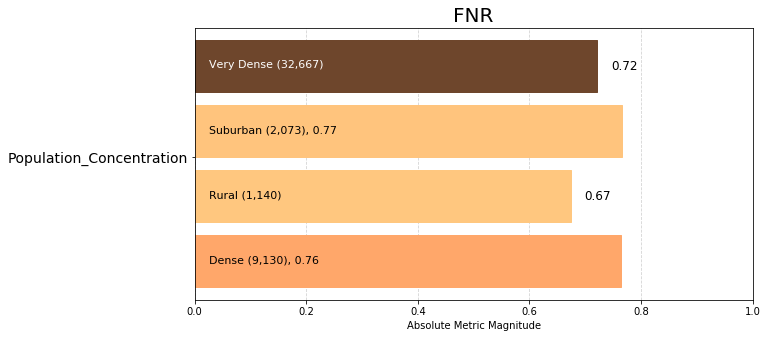

In [220]:
fnr = aqp.plot_group_metric(xtab, 'fnr')
#From this we can tell that "Very Dense Populations are the largest "
#complex policy problem, rural less people, but also less power and 
#and historical have dumpped waste tehre 

In [167]:
b = Bias()

In [168]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, ref_groups_dict={'Population_Concentration':'Very Dense'}, alpha=0.05, mask_significance=True)
bdf.style

get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,1,binary 0/1,4703,Population_Concentration,Dense,0.236014,0.958054,0.266724,0.280384,0.0419458,0.763986,0.733276,0.719616,938,8192,0.199447,0.102738,263,2185,6007,675,2860,6270,9130,46994,0.313253,0.293584,1.05044,0.976709,1.06519,1.28572,1.20695,1.05813,0.849009,0.992549,0.925213,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense
1,1,binary 0/1,4703,Population_Concentration,Rural,0.32626,0.934469,0.262668,0.289017,0.0655308,0.67374,0.737332,0.710983,173,967,0.036785,0.151754,50,254,713,123,377,763,1140,46994,0.330702,0.0541471,1.5516,0.964991,1.09799,1.26617,1.88559,0.933142,1.17365,0.968115,0.93033,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense
2,1,binary 0/1,4703,Population_Concentration,Suburban,0.23445,0.952974,0.258342,0.316279,0.0470263,0.76555,0.741658,0.683721,215,1858,0.0457155,0.103714,68,480,1378,147,627,1446,2073,46994,0.30246,0.0672926,1.06042,0.92799,1.20156,1.24532,1.35314,1.0603,0.843382,0.987285,0.935788,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense
3,1,binary 0/1,4703,Population_Concentration,Very Dense,0.277988,0.965246,0.207451,0.263224,0.0347535,0.722012,0.792549,0.736776,3195,29472,0.679354,0.0978051,841,6114,23358,2354,8468,24199,32667,46994,0.259222,1,1,1,1,1,1,1,1,1,1,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense
4,1,binary 0/1,4703,Population_Concentration,nan,0.222597,0.964055,0.255827,0.274725,0.0359454,0.777403,0.744173,0.725275,182,1802,0.0386987,0.0917339,50,461,1341,132,593,1391,1984,46994,0.298891,0.056964,0.937925,0.984389,1.04369,1.23319,1.03429,1.07672,0.800744,0.998765,0.938962,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense


In [221]:
bdf = b.get_disparity_predefined_groups(xtab, original_df=df, 
                                        ref_groups_dict={'Population_Concentration':'Very Dense' 
                                                         }, 
                                        alpha=0.05, mask_significance=True)
bdf.style




get_disparity_predefined_group()


,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity,ppr_ref_group_value,pprev_ref_group_value,precision_ref_group_value,fdr_ref_group_value,for_ref_group_value,fpr_ref_group_value,fnr_ref_group_value,tpr_ref_group_value,tnr_ref_group_value,npv_ref_group_value
0,1,binary 0/1,4521,Population_Concentration,Dense,0.236014,0.958054,0.266724,0.280384,0.0419458,0.763986,0.733276,0.719616,938,8192,0.207476,0.102738,263,2185,6007,675,2860,6270,9130,45010,0.313253,0.293584,1.05044,0.976709,1.06519,1.28572,1.20695,1.05813,0.849009,0.992549,0.925213,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense
1,1,binary 0/1,4521,Population_Concentration,Rural,0.32626,0.934469,0.262668,0.289017,0.0655308,0.67374,0.737332,0.710983,173,967,0.0382659,0.151754,50,254,713,123,377,763,1140,45010,0.330702,0.0541471,1.5516,0.964991,1.09799,1.26617,1.88559,0.933142,1.17365,0.968115,0.93033,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense
2,1,binary 0/1,4521,Population_Concentration,Suburban,0.23445,0.952974,0.258342,0.316279,0.0470263,0.76555,0.741658,0.683721,215,1858,0.0475559,0.103714,68,480,1378,147,627,1446,2073,45010,0.30246,0.0672926,1.06042,0.92799,1.20156,1.24532,1.35314,1.0603,0.843382,0.987285,0.935788,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense
3,1,binary 0/1,4521,Population_Concentration,Very Dense,0.277988,0.965246,0.207451,0.263224,0.0347535,0.722012,0.792549,0.736776,3195,29472,0.706702,0.0978051,841,6114,23358,2354,8468,24199,32667,45010,0.259222,1,1,1,1,1,1,1,1,1,1,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense,Very Dense


In [223]:
calculated_disparities = b.list_disparities(bdf)
disparity_significance = b.list_significance(bdf)

In [224]:

# View disparity metrics added to dataframe
bdf[['attribute_name', 'attribute_value'] +  calculated_disparities + disparity_significance]

,attribute_name,attribute_value,ppr_disparity,pprev_disparity,precision_disparity,fdr_disparity,for_disparity,fpr_disparity,fnr_disparity,tpr_disparity,tnr_disparity,npv_disparity
0,Population_Concentration,Dense,0.293584,1.050438,0.976709,1.065192,1.285718,1.206951,1.058134,0.849009,0.992549,0.925213
1,Population_Concentration,Rural,0.054147,1.551600,0.964991,1.097991,1.266168,1.885588,0.933142,1.173649,0.968115,0.930330
2,Population_Concentration,Suburban,0.067293,1.060419,0.927990,1.201560,1.245316,1.353138,1.060301,0.843382,0.987285,0.935788
3,Population_Concentration,Very Dense,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


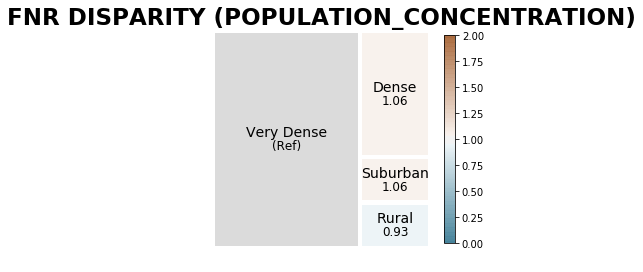

In [226]:
#plot false negative rate relation 
aqp.plot_disparity(bdf, group_metric='fnr_disparity', 
                   attribute_name='Population_Concentration')